In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt


pavia = sio.loadmat('data/PaviaU_cube.mat')
hsi = pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('data/PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends["endmembers"]

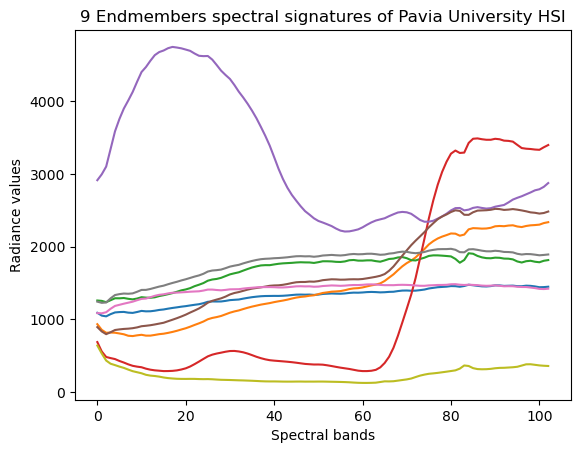

In [2]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

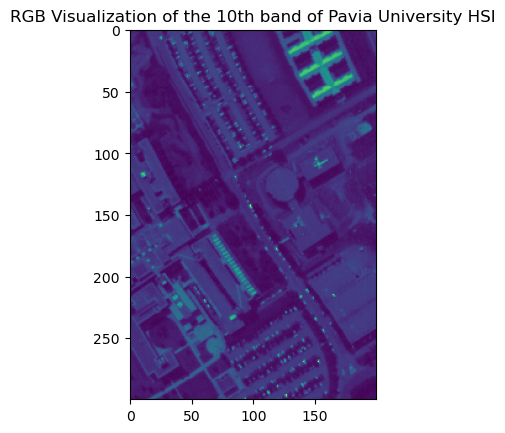

In [3]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('data/PaviaU_ground_truth.mat')
labels = ground_truth['y']

fig = plt.figure()
plt.imshow(hsi[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https:-//docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

First of all, we need to only keep mixed pixels, aka pixels that corresponds to geographical areas with different geological features. We have fortunately been supplied with the labels of the pure pixels (pixels that only correspond to a single material).

In [4]:
labels.shape, hsi.shape

((300, 200), (300, 200, 103))

In [5]:
mask = labels == 0
mixed_hsi = np.where(mask[:,:, None] , hsi, 0)
mixed_hsi.shape

(300, 200, 103)

Let's have a look at which features we will be running our analysis on.

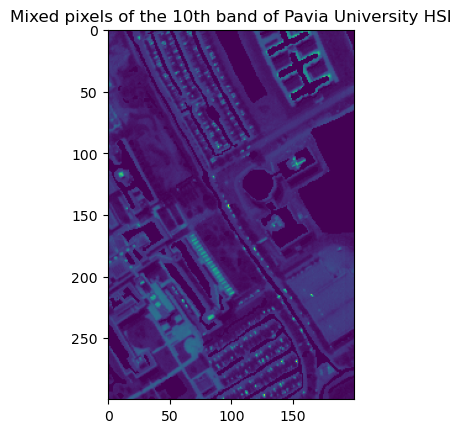

In [6]:
fig = plt.figure()
plt.imshow(mixed_hsi[:,:,10])
plt.title('Mixed pixels of the 10th band of Pavia University HSI')
plt.show()

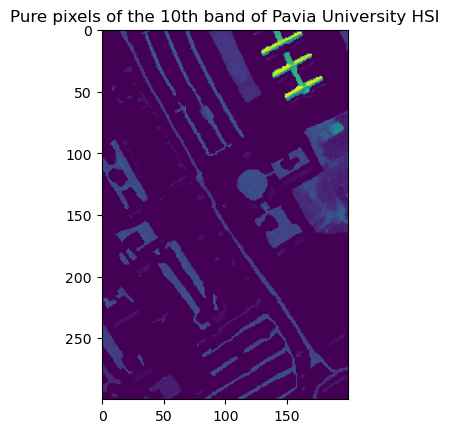

In [7]:
mask = labels != 0
pure_hsi = np.where(mask[:,:, None] , hsi, 0)
pure_hsi.shape

fig = plt.figure()
plt.imshow(pure_hsi[:,:,10])
plt.title('Pure pixels of the 10th band of Pavia University HSI')
plt.show()

In [8]:
from prettytable import PrettyTable 


def arrays_stats(arrays: list[np.ndarray], names: list[str]|None = None, decimals: int = 2) -> PrettyTable:
    """
    Generate statistics for a list of NumPy arrays and create a PrettyTable.

    :param arrays: List of NumPy arrays for which statistics are calculated.
    :type arrays: list[np.ndarray]

    :param names: List of names corresponding to each array. If None, default names will be generated based on array indices. Default is None.
    :type names: list[str]|None

    :param decimals: Number of decimals to round the statistical values. Default is 2.
    :type decimals: int

    :return: Table containing statistics for each array, including mean, standard deviation, minimum, maximum, first quartile (Q1), and third quartile (Q3).
    :rtype: PrettyTable
    """
    stats_table = PrettyTable(["Array", "Shape", "Mean", "Std", "Min", "Max", "Q1", "Q3"])
    
    if type(decimals) is not int:
        raise ValueError("The 'decimals' argument must be an integer.")

    if names is None:
        names = [i for i in range(len(arrays))]
        
    if len(names) != len(arrays):
        raise ValueError("Names and arrays must have the same length.")
        
    for name, array in zip(names, arrays):
        stats_table.add_row([name, array.shape, round(array.mean(), decimals),  round(array.std(), decimals),  
                             round(array.min(), decimals), round(array.max(), decimals), 
                             round(np.quantile(array, 0.25), decimals), round(np.quantile(array, 0.75), decimals)])
    return stats_table

In [9]:
y = hsi
y1 = y.reshape(y.shape[2], (y.shape[0]*y.shape[1]))
x1 = endmembers

x1.shape, y1.shape

((103, 9), (103, 60000))

In [10]:
arrays_stats([y1, x1], names=["y1", "x1"])

Array,Shape,Mean,Std,Min,Max,Q1,Q3
y1,"(103, 60000)",1480.0,891.47,0,8000,796.0,1987.0
x1,"(103, 9)",1551.32,926.43,128.24,4745.65,1093.66,1897.79


In [11]:
focus_point = (30, 150)

In [12]:
def abundance_matrix(model) -> np.ndarray:
    return model.coef_.reshape((300, 200, 9))

In [13]:
from sklearn.linear_model import LinearRegression

base_model = LinearRegression(fit_intercept=True).fit(x1, y1)
base_abundance = abundance_matrix(base_model)
base_abundance[focus_point]

array([  9.4860257 ,  -1.09972437,   7.29718391,   0.50633153,
         0.11154806,   0.38550746, -12.03692148,  -9.2428594 ,
        -9.61408365])

In [14]:
pos_model = LinearRegression(fit_intercept=False, positive=True).fit(x1, y1)
pos_abundance = abundance_matrix(pos_model)
pos_abundance[focus_point]

array([0.        , 0.        , 0.47847075, 0.        , 0.16461236,
       0.        , 0.        , 0.        , 0.73790708])

In [15]:
from sklearn.linear_model import Lasso


lasso = Lasso(fit_intercept=False, positive=True, tol=1e-3, max_iter=int(1e5)).fit(x1, y1)
lasso_abundance = abundance_matrix(lasso)
lasso_abundance[focus_point]

array([0.        , 0.        , 0.47942755, 0.        , 0.16446791,
       0.        , 0.        , 0.        , 0.73377197])

In [19]:
from tqdm import tqdm
from scipy.optimize import minimize 
from scipy.optimize import nnls 


def lsq_sum_to_one(A: np.ndarray, b: np.ndarray, 
                    bounds :list[list[float|None]], 
                    verbose: bool=True) -> np.ndarray:
    
    coefficients = np.zeros((A.shape[1], b.shape[1]))
    
    # define minimization function
    min_func = lambda x, A, b: np.linalg.norm(A.dot(x) - b)
    
    #Define constraints and bounds
    cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}
    
    iterable = tqdm(range(y1.shape[1])) if verbose else range(y1.shape[1])

    for i in iterable:
        bi = b[:, i]
        #Use nnls to get initial guess
        x0, rnorm = nnls(A, bi)

        #Call minimisation subject to these values
        minout = minimize(min_func, x0, args=(A, bi), method='SLSQP', 
                          bounds=bounds,constraints=cons)
        x = minout.x
        coefficients[:, i] = x
        
    return coefficients

In [20]:
sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[None, None]])
sum1_coeffs.shape, np.isclose(sum1_coeffs.sum(axis=0), 1).sum()

100%|############################################################################| 60000/60000 [11:13<00:00, 89.10it/s]


((9, 60000), 60000)

In [22]:
pos_sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[0,None]])
pos_sum1_coeffs.shape, np.isclose(pos_sum1_coeffs.sum(axis=0), 1).sum()

100%|###########################################################################| 60000/60000 [06:33<00:00, 152.58it/s]


((9, 60000), 58863)

In [ ]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()